# Reduction of GIANO data

In [92]:
#------ manually fix import for now
import sys, os
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.align import Align
from redcross.planet import Planet

c = 2.99e5
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp33/pos{:}/'.format(position)

# dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))

read_from_files = True # set to `True` the first time running it

if read_from_files:
    files = sorted(glob.glob(data_dir+'*_{:}_*.fits'.format(position))) # select files
    dc = read_giano(files)
    dc.save(data_dir+'datacube_input_pos{:}.npy'.format(position))
else:
    dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))
    

/home/dario/AstronomyLeiden/MRP/wasp33/posB/datacube_input_posB.npy saved...


In [94]:
def prange(planet, key):
    attr = getattr(planet, key)
    displ_list = [attr[0], attr[int(len(attr)/2.)], attr[-1]]
    print('{:10}: {:.2f} - {:.2f} - {:.2f}'.format(key, *displ_list))
    return None

planet_file = '/home/dario/AstronomyLeiden/MRP/wasp33/wasp33.dat'
planet = Planet(planet_file, **dc.get_header().header)

prange(planet, 'phase')
prange(planet, 'airmass')


phase     : 0.43 - 0.59 - 0.74
airmass   : 1.97 - 1.01 - 1.61


total/out-of-eclipse
61 / 43


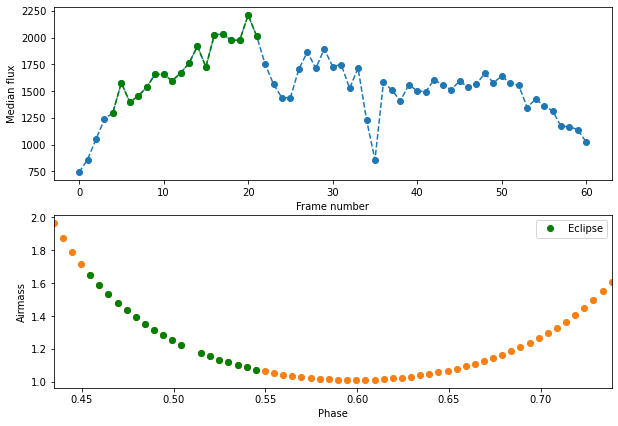

In [95]:
# Get eclipse mask (True where planet is IN eclipse)
ecl = planet.mask_eclipse(return_mask=True)

fig, ax = plt.subplots(2,1, figsize=(10,7))

flux = np.median(dc.flux, axis=(0,2))
ax[0].plot(np.arange(0, dc.nObs), flux ,'--o')
ax[0].plot(np.arange(0, dc.nObs)[ecl], flux[ecl] ,'--og')


ax[1].plot(planet.phase, dc.airmass,'o', alpha=0.3)
ax[1].plot(planet.phase, dc.airmass,'o')
ax[1].plot(planet.phase[ecl], dc.airmass[ecl],'og', label='Eclipse')

ax[1].legend()
ax[0].set(ylabel='Median flux', xlabel='Frame number')
ax[1].set(xlabel='Phase', ylabel='Airmass', xlim=(planet.phase.min(), planet.phase.max()))

print('total/out-of-eclipse')
print('{:} / {:}'.format(planet.phase.size, planet.phase[~ecl].size))

# discard frames with very-low flux
# mask = flux < 200
# bad_files = int(np.argwhere(mask==True)[0])
# files[bad_files]

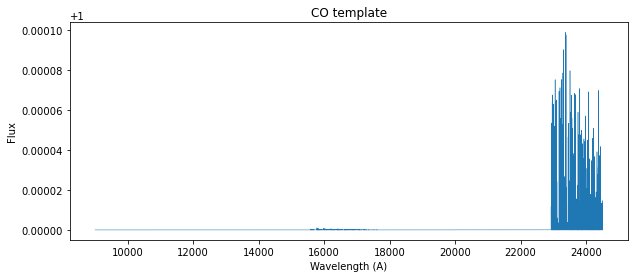

In [96]:
# species = 'OH_main_iso'
species = 'CO_main_iso'
species_name = species.split('_')[0]

template_path = 'data/template_giano_{:}_2500K.npy'.format(species)
twave, tflux = np.load(template_path)

# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux)

# plot template
fig, ax = plt.subplots(1, figsize=(10,4))
template.plot(ax=ax, lw=0.5)
ax.set(xlabel='Wavelength (A)', ylabel='Flux', title='{:} template'.format(species_name))
plt.show()

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp33/posB/datacube_input_posB.npy
Input (2, 61, 2048)
Output (2, 43, 2048)
(2, 43, 2048)
(4, 43, 1024)
--> 5.76 % of pixels masked
--> 15.92 % of pixels masked


/home/dario/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


outliers = 4.07e-03 %
--> 0.00 % of pixels masked


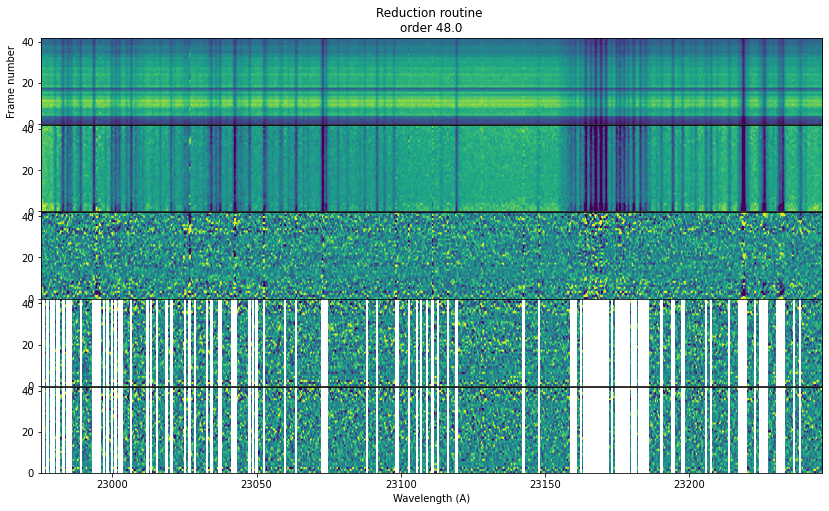

In [97]:
%matplotlib inline
fig, ax = plt.subplots(5,figsize=(14,8))
plt.subplots_adjust(hspace=0.01)

# First select an order
orders = [48, 49]
dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position)).order(orders)
dc.mask_frames(ecl, debug=True)
planet = Planet(planet_file, **dc.get_header().header) # update planet after masking frames
# Wavelength solution 
dc.wlt = np.median(dc.wlt, axis=1)

dcs = dc.split_orders(debug=True)

half_order = 0
dco = dcs.order(half_order)

    
    

# Original
dco.imshow(ax=ax[0])

# Remove continuum
dco.remove_continuum().sigma_clip()



# Inject signal
factor = 100. # strenght of the injection (1 is the expected planetary signal, set to 0 to ignore this step)
if factor > 0:
    dco.inject_signal(planet, template, factor=factor)

# dco.sigma_clip(debug=True)
dco.imshow(ax=ax[1])

# Airmass detrend
dco.airmass_detrend()
s = 2.
dco.imshow(ax=ax[2], stretch=s)

#   TESTING
debug = True
dco.mask_cols(sigma=1.0, mode='flux', nan=True, debug=debug)
dco.mask_cols(sigma=1.0, mode='flux_err', nan=True, debug=debug)

# SysRem
dco.sysrem(8)
dco.imshow(ax=ax[3], stretch=s)

# High-pass filter
dco.high_pass_gaussian(15) # window in [pixels]
dco.imshow(ax=ax[4], stretch=s)

#     # 6. Sigma-clip again
dco.sigma_clip(nSigma=3., debug=debug)
# 7. Mask noisy columns
dco.mask_cols(sigma=3., mode='flux_err', nan=True, debug=debug)

[ax[k].set_xticks([]) for k in range(3)]
ax[0].set(ylabel='Frame number', title='Reduction routine \norder {:}'.format(orders[0]+ (half_order/2.)))
ax[len(ax)-1].set(xlabel='Wavelength (A)')


plt.show()
# outname = 'plots/reduction_routine_order{:}.png'.format(order/2.)
# fig.savefig(outname, dpi=200, bbox_inches='tight', facecolor='white')

In [129]:
def reduce_giano(dco_in, nSysRem=3, hpw=15, debug=False):
    dco = dco_in.copy()
    good_in = dco.wlt[~np.isnan(dco.wlt)].size
    
    dco.remove_continuum(mode='polyfit').sigma_clip(debug=debug)
#     dco.airmass_detrend()
    
#     # TESTING
#     dco.mask_cols(sigma=2., mode='flux', nan=True, debug=debug)
    dco.mask_cols(sigma=1.2, mode='flux_err', nan=True, debug=debug)
#     # 4. SysRem
    if nSysRem > 0.:
        dco.sysrem(nSysRem)
#     # 5. High-pass filter
    dco.high_pass_gaussian(hpw, 'subtract').sigma_clip(nSigma=3., debug=debug)
#     dco.mask_cols(sigma=3., mode='flux_err', nan=True, debug=debug)
    dco.mask_cols(sigma=1.5, mode='flux', nan=True, debug=debug)
    
    if debug:
        good_out = dco.wlt[~np.isnan(dco.wlt)].size
        print('Initial pixel channels = {:}'.format(good_in))
        print('Output pixel channels = {:}'.format(good_out))
        
    return dco

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp33/posA/datacube_input_posA.npy
Input (2, 61, 2048)
Output (2, 43, 2048)
(2, 43, 2048)
(4, 43, 1024)
outliers = 1.66e-03 %
--> 0.59 % of pixels masked
outliers = 2.57e-03 %
--> 7.32 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 943


/home/dario/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


outliers = 1.23e-03 %
--> 15.14 % of pixels masked
outliers = 2.70e-03 %
--> 8.50 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 782
outliers = 6.59e-04 %
--> 5.96 % of pixels masked
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...


/home/dario/AstronomyLeiden/MRP/redcross/examples/../src/redcross/sysrem.py:21: RuntimeWarning: divide by zero encountered in true_divide
  c_i = np.nansum((r_ij/err2).T*a_j, axis=1) / np.nansum((a_j**2/err2.T), axis=1)
/home/dario/AstronomyLeiden/MRP/redcross/examples/../src/redcross/sysrem.py:21: RuntimeWarning: invalid value encountered in true_divide
  c_i = np.nansum((r_ij/err2).T*a_j, axis=1) / np.nansum((a_j**2/err2.T), axis=1)


outliers = 1.44e-02 %
--> 9.18 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 869
outliers = 1.57e-03 %
--> 26.56 % of pixels masked
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
outliers = 1.05e-02 %
--> 4.98 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 701
19.56 % of pixels have been masked
Horizontal slice at Kp = 251.7 km/s
Vertical slice at Vrest = 6.5 km/s
Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp33/posB/datacube_input_posB.npy
Input (2, 61, 2048)
Output (2, 43, 2048)
(2, 43, 2048)
(4, 43, 1024)
outliers = 0.00e+00 %
--> 20.70 % of pixels masked
outliers = 3.84e-03 %
--> 7.13 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 739


/home/dario/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


outliers = 2.27e-05 %
--> 16.89 % of pixels masked
outliers = 5.31e-03 %
--> 6.64 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 783
outliers = 2.27e-04 %
--> 0.59 % of pixels masked
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...


/home/dario/AstronomyLeiden/MRP/redcross/examples/../src/redcross/sysrem.py:21: RuntimeWarning: divide by zero encountered in true_divide
  c_i = np.nansum((r_ij/err2).T*a_j, axis=1) / np.nansum((a_j**2/err2.T), axis=1)
/home/dario/AstronomyLeiden/MRP/redcross/examples/../src/redcross/sysrem.py:21: RuntimeWarning: invalid value encountered in true_divide
  c_i = np.nansum((r_ij/err2).T*a_j, axis=1) / np.nansum((a_j**2/err2.T), axis=1)


outliers = 1.28e-02 %
--> 8.01 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 936
outliers = 3.86e-04 %
--> 19.73 % of pixels masked
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
outliers = 1.09e-02 %
--> 7.23 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 748
21.73 % of pixels have been masked
Horizontal slice at Kp = 232.2 km/s
Vertical slice at Vrest = -11.5 km/s


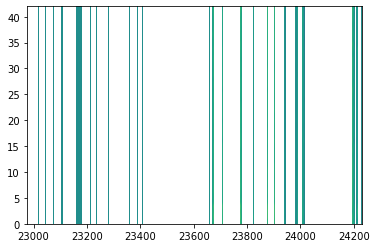

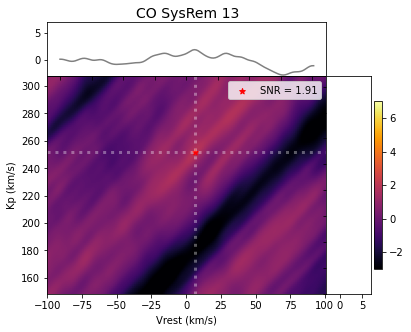

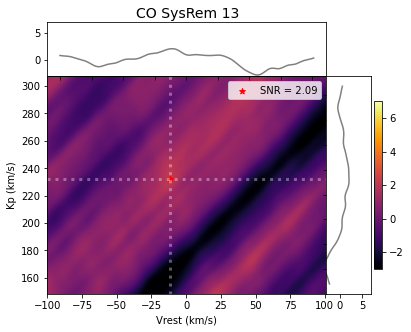

In [132]:
# position = 'B'
orders = [48, 49]
positions = ['A', 'B']


# Define parameters for cross-correlation and Kp-Vsys map
hpw = 15
# dRV = 2.7
dRV = 1.5
RVt = np.arange(-450,451, dRV)
dkp, kp_amp = dRV, 80 # km/s
vrest_amp, dvrest = 100, dRV # km /s
v_range = [-3.,7.0] # fix color scale

nsys = 13

kpv_AB = []
for position in positions:
    data_dir = '/home/dario/AstronomyLeiden/MRP/wasp33/pos{:}/'.format(position)


    dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position)).order(orders)

    dc.mask_frames(ecl, debug=True)
    planet = Planet(planet_file, **dc.get_header().header) # update planet after masking frames

    dc.wlt = np.median(dc.wlt, axis=1)
    dcs = dc.split_orders(debug=True)

   

    wave, flux, flux_err = ([] for _ in range (3))    
    #     for o in range(dcs.shape[0]):
    for o in range(4): 
    #         print('Order {:}'.format(orders[0]+o))
        dco1 = reduce_giano(dcs.order(o), nsys, hpw, debug=True)


        wave.append(dco1.wlt) # changing the shape, can't overwrite for each order
        flux.append(dco1.flux)
        flux_err.append(dco1.flux_err)

    # Merge all reduced half-orders
    dcm = Datacube(flux=np.hstack(flux), wlt=np.hstack(wave), flux_err=np.hstack(flux_err))
    dcm.imshow()

    nans = np.isnan(dcm.wlt)
    frac_masked = nans[nans==True].size / nans.size
    print('{:.2f} % of pixels have been masked'.format(100*frac_masked))

    #   Apply BERV correction (shift each frame)
    dcm.to_stellar_frame(-dcs.BERV) 

    #   Run CCF and KpV 
    ccf = CCF(rv=RVt, template=template).run(dcm, weighted=True)
    kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)

    kpv.run().fancy_figure(peak=None, outname=None, title='CO SysRem {:}'.format(nsys), v_range=v_range)
    kpv_AB.append(kpv.snr)
# snr_sys[k,] = np.array([nsys, kpv.peak_snr])

Horizontal slice at Kp = 232.2 km/s
Vertical slice at Vrest = -10.0 km/s


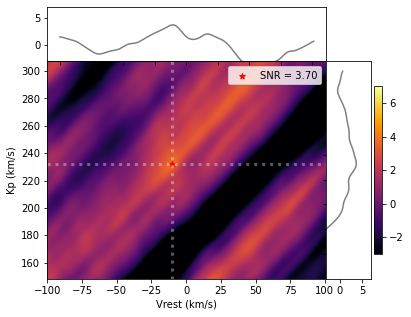

In [133]:
kpv_merged = kpv.copy()
kpv_merged.snr = np.sum(np.array(kpv_AB), axis=0)
kpv_merged.fancy_figure(v_range=v_range)